In [1]:
import numpy as np
from numpy.linalg import inv   #if needed
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import scipy.special
from scipy.special import eval_legendre, eval_hermitenorm

#Polynomial Chaos E. terms ----------------------------------------------

def hermite(x,n):
    return eval_hermitenorm(n,x)/np.sqrt(scipy.special.factorial(n))

def legendre(x,n):
    return eval_legendre(n,x)*np.sqrt(2*n+1)

def scalelegendre(x,new_min,new_max): 
    return ((new_min+new_max)+((new_max-new_min)*x))/2

def scalehermite(x,mean,sigma):
    return mean+sigma*x

# def NORMleg1(x,oldmin,oldmax,newmin,newmax):    # scaling linearly X to new domain limits
    
#     return newmin + ((x-oldmin)*(newmax-newmin)/(oldmax-oldmin))

def distance(x,xk):                        #multidimensional distance between 2 samples
    d=np.zeros((len(x),len(xk)))
    
    for j in range(0,len(xk)):
        for i in range(0,len(x)):
            d[i,j] = d[i,j]+np.sqrt(np.sum((x[i]-xk[j])**2))
    return d


# def VoronoiCell(x,xn):   #given x [single value] return the index of the closest xn [1D array]
#     dist=abs(distance(x,xn))
#     voro=np.argmin(np.squeeze(dist))
#     return voro

In [4]:
# #ground truth function----------------------------------------------------

def functiontest(x):
#     return -(np.sin(x*7)+np.cos(14*x))*(x**2)*np.exp(-4*x)
    return x * np.sin(x)


# https://rprepo.readthedocs.io/en/latest/reliability_problems.html#rp201

def gfun_53(x):
    """Performance function for reliability problem 53.

    Parameters
    ----------
        x : numpy.array of float(s)
            Values of independent variables: columns are the different parameters/random variables (x1, x2,...xn) and rows are different parameter/random variables sets for different calls.

    Returns
    -------
        g_val_sys : numpy.array of float(s)
            Performance function value for the system.
        g_val_comp : numpy.array of float(s)
            Performance function value for each component.
        msg : str
            Accompanying diagnostic message, e.g. warning.
    """
#     import numpy as np
    # expected number of random variables/columns
    nrv_e = 2

    g = float('nan')
    msg = 'Ok'
    x = np.array(x, dtype='f')

    n_dim = len(x.shape)
    if n_dim == 1:
        x = np.array(x)[np.newaxis]
    elif n_dim > 2:
        msg = 'Only available for 1D and 2D arrays.'
        return float('nan'), float('nan'), msg

    nrv_p = x.shape[1]
    if nrv_p != nrv_e:
        msg = f'The number of random variables (x, columns) is expected to be {nrv_e} but {nrv_p} is provided!'
    else:
        g = np.sin(5*x[:, 0]/2) + 2 - (x[:, 0]**2 + 4)*(x[:, 1] - 1)/20

    g_val_sys = g
    g_val_comp = g
    return g_val_sys, g_val_comp, msg

In [2]:
# EXPERIMENTAL MATRIX 
# evaluation of product combinations for multivariate function with degree <= "p" -----------------

def info_matrix (X,alpha):    # X must be normalized for polynomial evaluations
    
    #alpha = polynomial indices to be combined
    
    fx = np.zeros ((len(X), len(alpha))) 

    for i in range (0,len(X)):
        for j in range (0, len(alpha)):
            fx[i,j]=M1(X[i,0],alpha[j,0])*M2(X[i,1],alpha[j,1])  #it has to increase per dimension 

    return fx

# Matern correlation R(xr-xn) ---------------------------------------------------------------------

def matern(xr,xn,theta,v):     
    #theta, l, hyperparameter (length scaled)
    #matern parameter, v can be 3/2, 5/2
    
    d=distance(xr,xn)                 #eucledian distance
    R=np.zeros((len(xr),len(xn)))
    
    if v == 3/2:
        R = (1+ np.sqrt(3)*d/theta)* np.exp(-(np.sqrt(3)*d/theta))
    elif v == 5/2:
        R = ((1+ (np.sqrt(5)*d/theta) + (5/3)*(d/theta)**2 )* np.exp(-(np.sqrt(5)*d/theta)))
    return R

# Kriging noise-free MLE Dubourg (2011); Santner et al. (2003) ---------------------------------
# returns B_hat and sigma^2
def coefficients(F,xn,y,l,v):   
    
    R=matern(xn,xn,l,v)    # Correlation matrix R between observations
    
    R_inv= np.linalg.inv(R)
    left_r =  np.linalg.inv((F.T @ R_inv) @ F)
    right_r = F.T @ R_inv @ y
    B_hat = left_r @ right_r
    #----------------------------------------------------------
    ins = y - (F @ B_hat)              # Scale sigma^2
    left_s = (1/len(xn))*((ins).T)
    right_s = R_inv @ ins
    sig2 = left_s @ right_s
    
    return  B_hat, sig2

#------------------------------------------------------
def PCK_train (xn,y,p,theta):
    #xn, inputs training points
    #y, observations
    #p, degree of polynomial expansion
    #theta [ l, hyperparameter (length scaled); v, matern coefficient ]
    #---------------------------------------------------
    
    # information matrix based on observations and a chosen polynomial expansion
    
    dim=xn.shape[1]
    indices = np.arange(0,p+1)     #polynomials indices to be combined (1 colum ver variable)
    comb = np.zeros((p**dim,dim))  #to store all possible combinations
    
    # CHECK DIMENSIONS (INCREASE 1 indices vector per dimension)
    #------------------------------------------------------------------------- #all possible combinations of indices
    comb = np.array(np.meshgrid(indices,indices)).T.reshape(-1,dim)     #(indices, indices, indices...) per dimension
    alpha = []                 #list of product combinations with degree <= "p" (truncation term)

    for i in range (0,len(comb)): 
        if (np.sum(comb[i]))<=p:  
            alpha.append(comb[i])

    alpha = np.array(alpha) #alpha for multivariate combination
    
    phi = info_matrix(xn,alpha)     #check the number of variables included 
    
    B, sig2 = coefficients(phi,xn,y,theta[0],theta[1])
    
    return B, sig2, phi, alpha

def PCK_predict (XN,xn,y,theta,modelpar1):
    # B, sig2, phi, alpha 
    B    = modelpar1[0]
    sig2 = modelpar1[1]
    phi  = modelpar1[2]
    alpha = modelpar1[3]
    
    #allocanting storage ------------------------------------------
    fx=np.zeros((len(XN),len(alpha[1])))
    rx=np.zeros((len(XN),len(xn)))
    Rn=np.zeros((len(xn),len(xn)))
    
    mean1=np.zeros(len(XN))
    mean2=np.zeros(len(XN))
    PCKmean=np.zeros(len(XN))
        
    ux=np.zeros((len(alpha[1]),len(XN)))
    term1=np.zeros((len(XN),len(XN)))
    term2=np.zeros((len(XN),len(XN)))
    variance=np.zeros((len(XN),len(XN)))
    
    #XN, inputs  predictions ---------------------------------------
    fx = info_matrix(XN,alpha)                # f(x) information matrix about the predictions
    rx= matern(XN,xn,theta[0],theta[1])       # r(x) correlation matrix between predictions and observations
    Rn= matern(xn,xn,theta[0],theta[1])       # R    correlation matrix between predictions
    Rn_inv = np.linalg.inv(Rn)                     # R inverse

    #---------------------------------------------- Mean prediction
    mean1 = fx @ B 
    mean2 = rx @ Rn_inv @ (y - (phi @ B))
    PCKmean = mean1+mean2
    #---------------------------------------------- Variance prediction
    ux= ( phi.T @ Rn_inv @ rx.T) - fx.T

    term1 = rx @ Rn_inv @ rx.T
    term2 = ux.T @ np.linalg.inv(phi.T @ Rn_inv @ phi) @ ux

    variance = sig2 * ( 1 - term1 + term2)

    variaDiag=np.diagonal(variance) 
    
    return PCKmean, variaDiag

In [12]:
#definition of input parameters----------------------------------------------

function = gfun_53   #choose the ground truth function

dim=2       # dimensionality
n=40         # observations
seed=0      # fixing seed random number generator

np.random.seed(seed)         #fixing seed random number generator

xn = np.zeros((int(n), dim))      #normalized training points
xr = np.zeros((int(n), dim))      #scaled training points

#-----------------------------------------------------random Variable 1
M1=hermite              #type of polynomial for PCE

x1mean = 1.5                           
x1sigma = 1.0

xn[:,0] = np.random.normal(0,1,n)                             
xr[:,0] = scalehermite(xn[:,0],x1mean,x1sigma) 
 
#-----------------------------------------------------random Variable 2
M2=hermite             #type of polynomial for PCE

x2mean = 2.5              
x2sigma = 1.0  

xn[:,1] = np.random.normal(0,1,n)                             
xr[:,1] = scalehermite(xn[:,1],x2mean,x2sigma) 

#=====================================================
# Evaluation of observations 
y=function(xr)          #Observations
y=y[0]

In [16]:
#optimizing kernell-hyperparameters and fitting GP regressor with Scikit-learn package----------------------------
kernel = 1 * RBF(length_scale=1.5, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(xn, y)
ke= gaussian_process.kernel_
print("kernel 1   :",ke)

kernel 1   : 2.29**2 * RBF(length_scale=1.21)


In [17]:
#train model -----------------------------------------

# kernel hyperparameters------------------------------
l=1.21   #length scale
v=5/2    #matern coefficient
theta=np.array([l,v])

#truncation term-------------------------------------
p = 2  #for each variable → same truncation , degree of expansion

modelpar1= PCK_train (xn,y,p,theta)    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)
modelpar1[0], modelpar1[1]   ## B, sig2,

(array([ 1.65634426, -0.2110505 ,  0.14910452, -0.41959025, -0.34930416,
        -0.14402763]),
 0.805278195020074)

In [27]:
# model predictions -----------------------------------------

ntest=200  # test points
seed=0      # fixing seed random number generator
np.random.seed(seed)         #fixing seed random number generator

# test points -------------------------------------------------
XR = np.zeros((int(ntest), dim))   #normalized test points
XN = np.zeros((int(ntest), dim))  #scaled test points
#variable 1 ---------------------------------------------------
XN[:,0] = np.random.normal(0,1,ntest)  
XR[:,0] = scalehermite(XN[:,0],x1mean,x1sigma)  
#variable 2 ---------------------------------------------------
XN[:,1] = np.random.normal(0,1,ntest)  
XR[:,1] = scalehermite(XN[:,1],x2mean,x2sigma)  

# mean1,var1 = PCK_predict(XN,xn,y,theta,modelpar1)

In [28]:
%%time
#predictions over a grid (for plotting)--------------------------------------------------

X1t,X2t = np.meshgrid(np.sort(XN[:,0]), np.sort(XN[:,1])) #grid over normalized points
Xt=np.stack((X1t,X2t),axis=2).reshape(-1,2) #sorting the random sampling (graphing purpose)

X1m,X2m = np.meshgrid(np.sort(XR[:,0]), np.sort(XR[:,1])) #grid over non-normalized points
Xtm=np.stack((X1m,X2m),axis=2).reshape(-1,2) #sorting the random sampling (graphing purpose)

yt=function(Xtm)    #test points
Mtest=yt[0]

response1=PCK_predict(Xt,xn,y,theta,modelpar1)   #model predictions over (ntest x ntest) points
mean1=response1[0]
var1=response1[1]


Wall time: 1min 7s


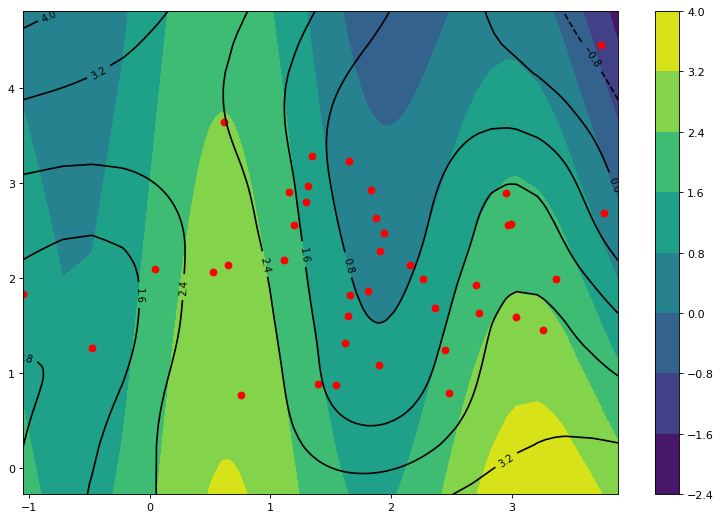

In [29]:
fig =plt.subplots(figsize=(12, 8), dpi=80)

levels = 7
cs = plt.contourf(np.sort(XR[:,0]), np.sort(XR[:,1]), Mtest.reshape(ntest,-1), levels)
cbar=plt.colorbar(cs)

csm = plt.contour(np.sort(XR[:,0]), np.sort(XR[:,1]), mean1.reshape(ntest,-1) ,levels, colors='k')
plt.clabel(csm, fontsize=9, inline=1)

plt.scatter(xr[:,0],xr[:,1],color='red')

cs.changed()

In [ ]:
# # # UQ lab ----------------------------------------------
# xr = np.array([7.5000,
#                 3.7500,
#                11.2500,
#                 1.8750,
#                 9.3750,
#                 5.6250,
#                13.1250,
#                 0.9375,
#                 8.4375,
#                 4.6875]).reshape(-1,1)

# xn = NORMleg1(xr,0.0,15.0,-1,1).reshape(-1,1)

# XN[:,0] = np.random.uniform(-1,1,ntest) 
# XR[:,0] = scalelegendre(XN[:,0],x1min,x1max)   

# # # UQ lab ----------------------------------------------
# B = np.array([7.82167423543062,
# 8.91027632414198,
# 9.47412206562374,
# 7.51776716025817,
# 4.02708022628571,
# -1.60396965559462]).reshape(-1,1)

# sig2 = 61.6836

In [ ]:
# xa=np.linspace(0,1,100)
# dista=distance(xa,xa)
# Ra=matern(xa,xa,0.096,3/2)

# plt.figure()
# plt.plot(dista,Ra)
# plt.show

# Kriging Model - 2 input var

In [11]:
#KRIGING SCIKIT LEARN---------------------------------------------------------------------
mean_prediction, std_prediction = gaussian_process.predict(Xt, return_std=True)

# MSE_krig_scik=np.sum((Mtest-mean_prediction)**2)
# print(MSE_krig_scik)


In [ ]:
mean_prediction.shape

In [ ]:
KrigMean, variaDiag = gaussian_process.predict(XR, return_std=True)

# LeaveOneOut_CrossValidation

In [ ]:
PC_loo=np.zeros(n)
KrigMeanloo=np.zeros(n)
KrigVarloo=np.zeros(n)
PC_looALL=np.zeros((n,ntest))
KrigMeanlooALL=np.zeros((n,ntest))
KrigVarlooALL=np.zeros((n,ntest))

#Generating PCK models for each reduced design of experiments 
for i in range (0,n):             
    y_loo=np.delete(y,[i])                              #y_n-i     leaving element i out the observations (M)
    xr_loo=np.delete(xr,[i*2,i*2+1]).reshape(-1,dim)      #x1r_n-i   leaving element i out the hermite inputs (xi)
    xn_loo=np.delete(xn,[i*2,i*2+1]).reshape(-1,dim)      #x_n-i     leaving element i out the inputs (xi)

    #Sampling matrix (A matrix) evaluation of the samples in a sparse p polynomials matrix from PCE
   
    A1_loo = np.zeros((n-1, p+1))
    A2_loo = np.zeros((n-1, p+1))
    phi_loo = np.zeros((n-1, len(alpha)))
    
    #generation of all orthogonal polynomials with degree smaller than p for each variable

    for j in range (0,n-1):
        for k in range (0,p+1):
            A1_loo[j,k] = np.array([M1(xn[j,0],k)])    #legendre

    for j in range (0,n-1):
        for k in range (0,p+1):
            A2_loo[j,k] = np.array([M2(xn[j,1],k)])    #hermite
    #-------------------------------------------------------------------------
    #Learning coefficients by Least-Square Minimization
    
    for j in range (0,n-1):
        for k in range (0,len(alpha)):
            phi_loo[j,k]=A1[j,alpha[k,0]]*A2[j,alpha[k,1]]  

    phi_tr_loo=phi_loo.transpose()
    phi_Inv_loo=np.linalg.inv(np.matmul(phi_tr_loo, phi_loo))
    Inv_phi_trans_loo=np.matmul(phi_Inv_loo,phi_tr_loo)
    Y_loo=np.matmul(Inv_phi_trans_loo,y_loo)     #coefficients for PC =f(M) observations
            
    # PCE mean prediction --------------leaving i-term out
    PC_loo[i] = PCE(xn[i,0],xn[i,1],alpha,Y_loo)       #Predictions on single i-point out following coefficients LOO
    PC_looALL[i] = PCE(X1,X2,alpha,Y_loo)              #Predictions on ALL test points following coefficients LOO
    
    # KRIGING mean--------------leaving i-term out
    [KrigMeanloo[i],KrigVarloo[i]]=GaussianPred(xr[i].reshape(-1,dim),xr_loo,y_loo,phi_loo,Y_loo,l,sig)    #Predictions on single i-point out following coefficients LOO
    [KrigMeanlooALL[i],KrigVarlooALL[i]]=GaussianPred(XR,xr_loo,y_loo,phi_loo,Y_loo,l,sig)                      #Predictions on ALL test points following coefficients LOO
    
mean_loo=PC_loo+KrigMeanloo
# e_loo=(M-mean_loo)**2
# sumat=np.divide(e_loo,KrigVarloo)
mean_looALL=PC_looALL+KrigMeanlooALL

# LOOCV=np.zeros(predict)
# cell=np.zeros(predict)
# for k in range (0,predict):  
#     voro = VoronoiCell(t2[k],xn)
#     LOOCV[k]= variaDiag[k]*(1+sumat[voro])
# #     cell[k] = voro

In [ ]:
from sklearn import linear_model
reg = linear_model.Lars(n_nonzero_coefs=5, normalize=False, precompute='auto')
# reg.fit([xr[:,0],xr[:,1]],y)
reg.fit(xr,y)
# ([[0, 0], [1, 1]], [0, 1])

In [ ]:
from sklearn.linear_model import LarsCV

LarsCV(fit_intercept=False, max_iter=5).fit(xr,y)